# Wheat Market Analysis
## EDA Notebook

### Matthew Garton - October 2018

**Purpose:** The purpose of this notebook is to perform some basic Exploratory Data Analysis on time series data of Wheat futures prices going back to 1959. 

**Context**: The ultimate goal of my project is to develop a trading strategy for commodity futures, which will include both prediction modeling to identify price patterns and trading opportunities as well as a rules-based algorithm to make trading decisions and manage risk.

Before modeling, it is necessary to explore and perform some statistical analysis on historical wheat futures prices.

In [2]:
# import necessary modules
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import datetime

from scipy.stats import normaltest
from scipy.signal import argrelextrema
from scipy.signal import find_peaks_cwt
import quandl

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read in the data
wheat = pd.read_csv('../data/wheat_final_EDA.csv', index_col='Date', parse_dates=True)

In [5]:
# High-Level Inspection of the data
display(wheat.describe().T)
wheat.info()

,count,mean,std,min,25%,50%,75%,max
Open,14939.0,357.982688,164.261666,1.146000e+02,250.000000,340.000000,432.000000,1295.000000
High,14939.0,361.538803,166.538580,1.151000e+02,252.375000,343.000000,436.000000,1300.000000
Low,14939.0,354.475610,161.870384,1.142000e+02,247.625000,337.500000,427.500000,1240.000000
Last,14939.0,357.832626,163.928843,1.142000e+02,250.000000,340.000000,431.750000,1280.000000
Change,1156.0,6.916609,5.506869,2.500000e-01,2.750000,5.750000,9.500000,34.250000
Settle,14939.0,357.836154,163.931125,1.142000e+02,250.000000,340.000000,431.750000,1280.000000
Volume,14939.0,19555.220229,22543.662344,0.000000e+00,3182.000000,11245.000000,28012.500000,231689.000000
Previous Day Open Interest,14939.0,70402.860165,71197.910276,0.000000e+00,14707.500000,45608.000000,102024.500000,348385.000000
5dma,14939.0,357.793272,163.694269,1.155879e+02,250.031619,340.505841,431.536464,1208.360982
10dma,14939.0,357.739703,163.451625,1.164469e+02,251.001233,340.866498,431.562443,1172.641218


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14939 entries, 1959-07-01 to 2018-10-18
Data columns (total 47 columns):
Open                          14939 non-null float64
High                          14939 non-null float64
Low                           14939 non-null float64
Last                          14939 non-null float64
Change                        1156 non-null float64
Settle                        14939 non-null float64
Volume                        14939 non-null float64
Previous Day Open Interest    14939 non-null float64
5dma                          14939 non-null float64
10dma                         14939 non-null float64
20dma                         14939 non-null float64
30dma                         14939 non-null float64
60dma                         14939 non-null float64
90dma                         14939 non-null float64
120dma                        14939 non-null float64
240dma                        14939 non-null float64
360dma                     

# EDA: Price History

First, I'll take a look at the full price history, as well as the differenced data, for the full time series, in order to get a 'big picture' sense of the history of the wheat market. Something that becomes apparent from a quick glance is that the market periodically (looks like once a decade) experiences a very sharp upwards trend, followed by a similarly steep downwards trend. Additionally, looking at the price data confirms what my outside reading and intuition would suggest, which is that large, persistent trends do exist and seem to dominate the price history. This presents an opportunity for a very profitable trading strategy if the trends can be identified early enough.

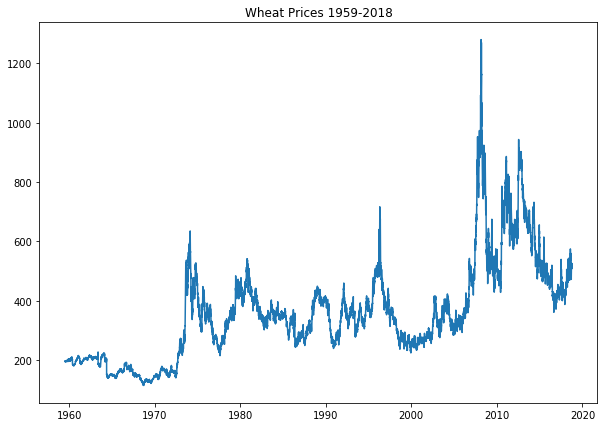

In [16]:
# first, take a look at the full price history
plt.figure(figsize=(10,7))
plt.plot(wheat['Settle'])
plt.title('Wheat Prices 1959-2018');

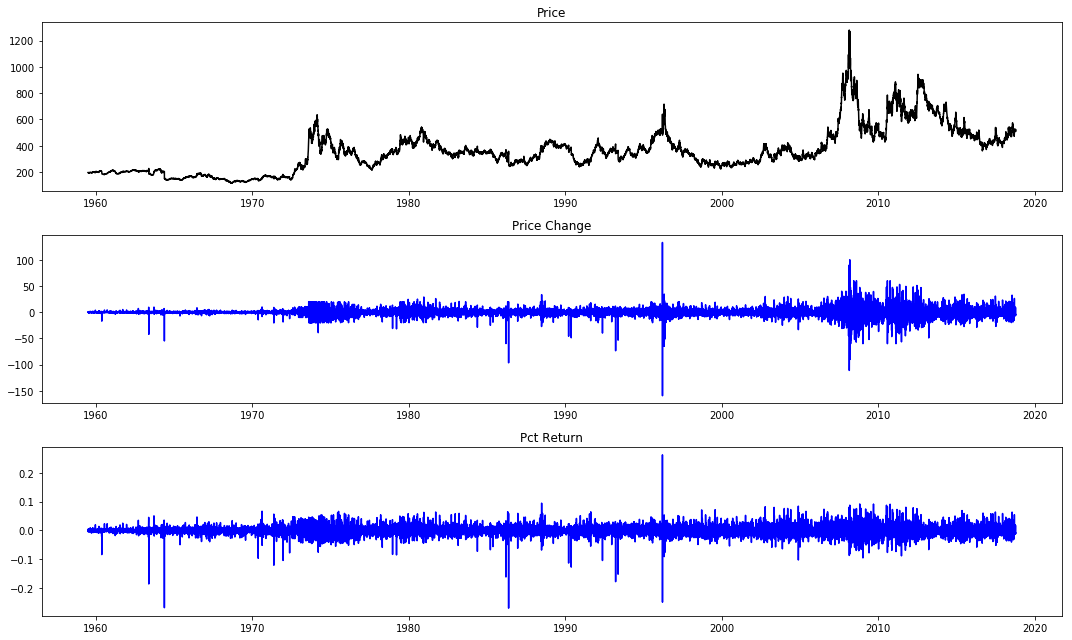

In [17]:
# plot price, price change, and percent change over time
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(15,9))
axes[0].plot(wheat['Settle'], color='k')
axes[0].set_title('Price')
axes[1].plot(wheat['Settle'].diff(), color='b')
axes[1].set_title('Price Change')
axes[2].plot(wheat['Settle'].pct_change(), color='b')
axes[2].set_title('Pct Return')
plt.tight_layout();

# EDA: Price History by Decade

To get a closer look at the data, I want to look at prices one decade at a time. The below plots confirm my earlier observation that large price trends seem to happen approximately once a decade.

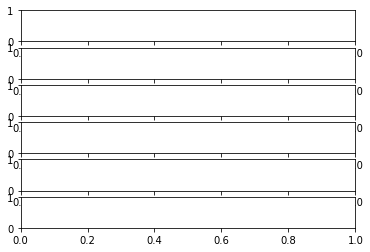

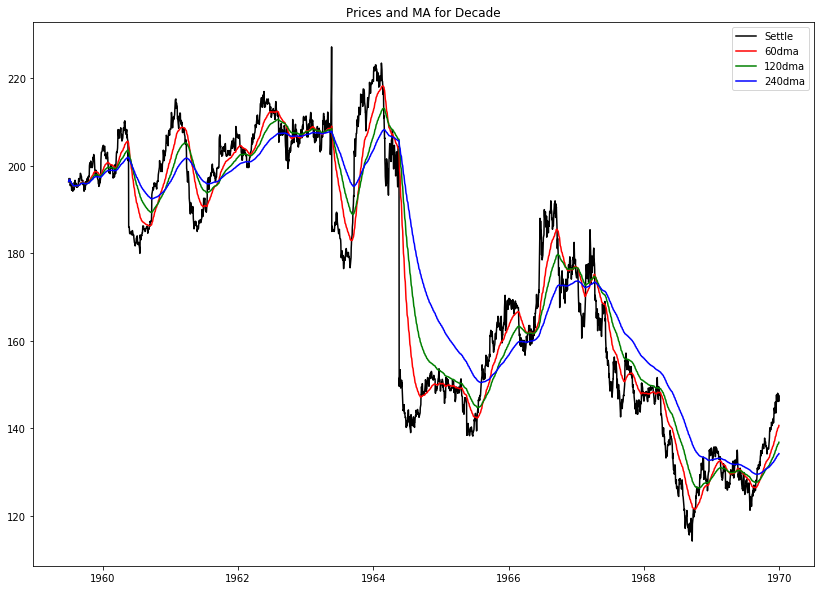

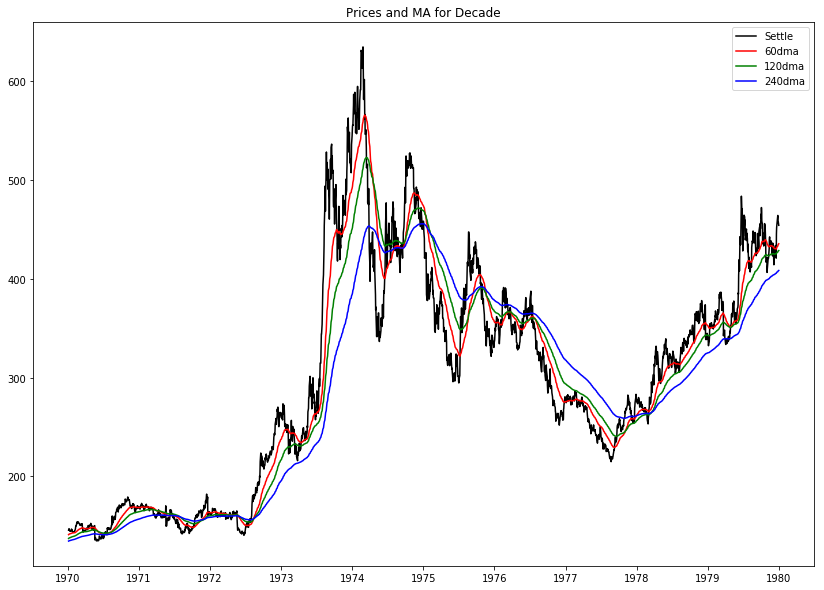

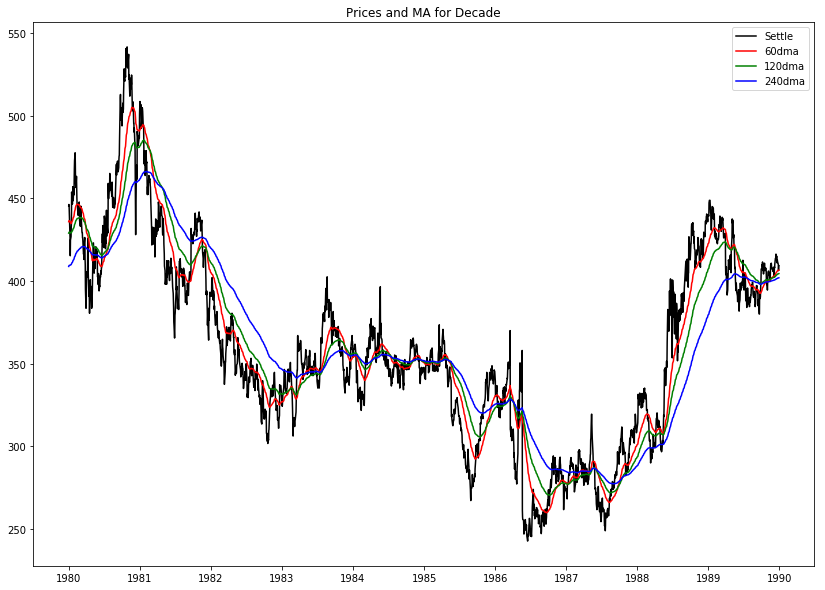

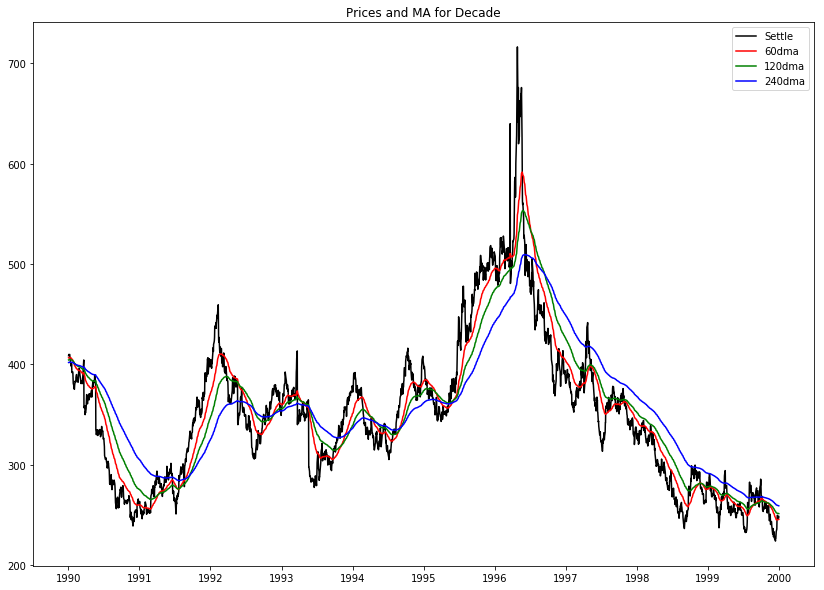

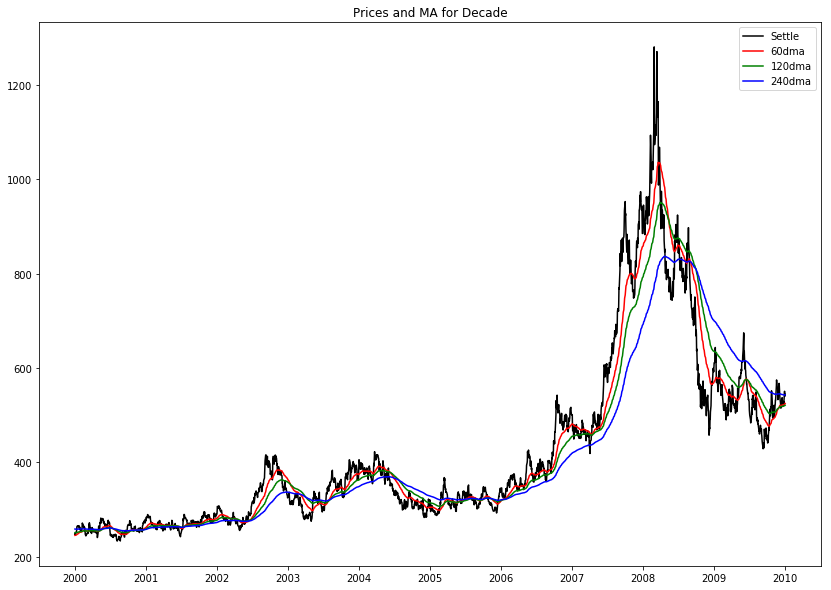

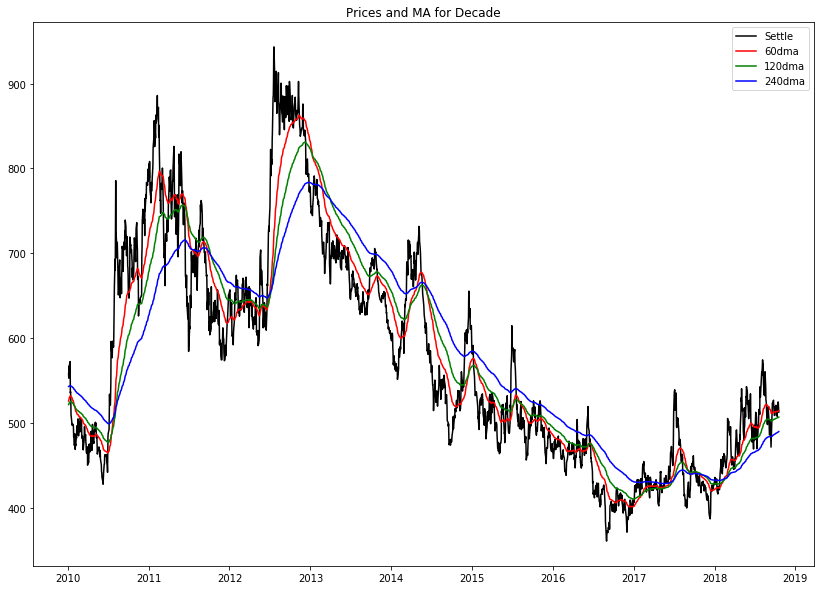

In [18]:
# Create dataframes for each decade in the dataset
sixties = wheat.loc['1959-07-01':'1969-12-31',:]
seventies = wheat.loc['1970-01-01':'1979-12-31',:]
eighties = wheat.loc['1980-01-01':'1989-12-31',:]
nineties = wheat.loc['1990-01-01':'1999-12-31',:]
noughties = wheat.loc['2000-01-01':'2009-12-31',:]
tens = wheat.loc['2010-01-01':'2019-12-31',:]

decades = [sixties, seventies, eighties, nineties, noughties, tens]

# subplots for each decade, to get a more granular view of the data
fig, axes = plt.subplots(nrows=len(decades), ncols=1);

for i, d in enumerate(decades):
    axes[i] = plt.figure(figsize = (14,10))
    axes[i] = plt.plot(d['Settle'], color = 'k')
    axes[i] = plt.plot(d['60dma'], color = 'r')
    axes[i] = plt.plot(d['120dma'], color = 'g')
    axes[i] = plt.plot(d['240dma'], color = 'b')
    axes[i] = plt.title('Prices and MA for Decade')
    axes[i] = plt.legend();

# EDA: Relationship between Price Level, Return, and Volatility

It looks like there is a positive relationship between price and volatility. Intuitively, this makes sense, as extreme moves tend to be to the upside, and given that wheat is a food product, I'm not surprised that the 'fear' in the market is to the upside. I'd like to examine this further. Below is a pairgrid exploring the relationships between price, vol, moving average, and volume. As expected, price is positively correlated to the moving average and to volatility, as well as volume. I believe this is driven by the extreme upward price spikes.

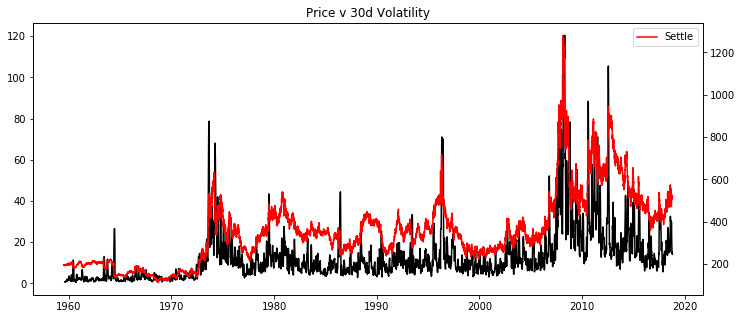

In [19]:
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(111)
ax1.plot(wheat['30d_vol'].dropna(), color='k')

ax2 = ax1.twinx()
ax2.plot(wheat['Settle'],color='r',)

plt.title('Price v 30d Volatility')
plt.legend();

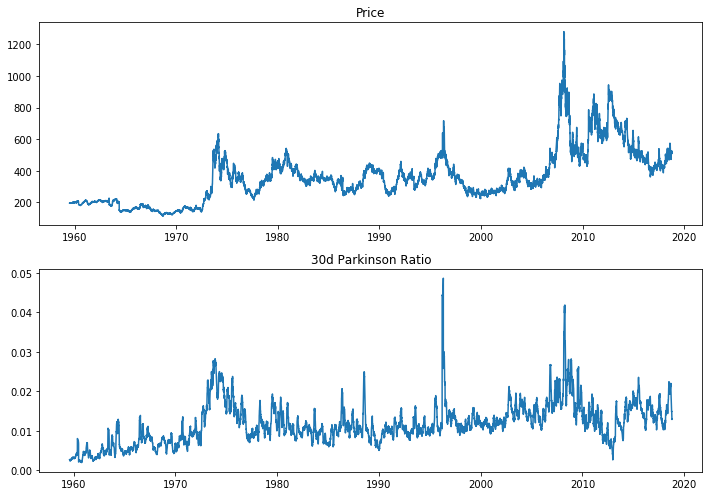

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,7))
ax[0].plot(wheat['Settle'])
ax[0].set_title('Price')
ax[1].plot(wheat['30d_parkinson'])
ax[1].set_title('30d Parkinson Ratio')
plt.tight_layout();

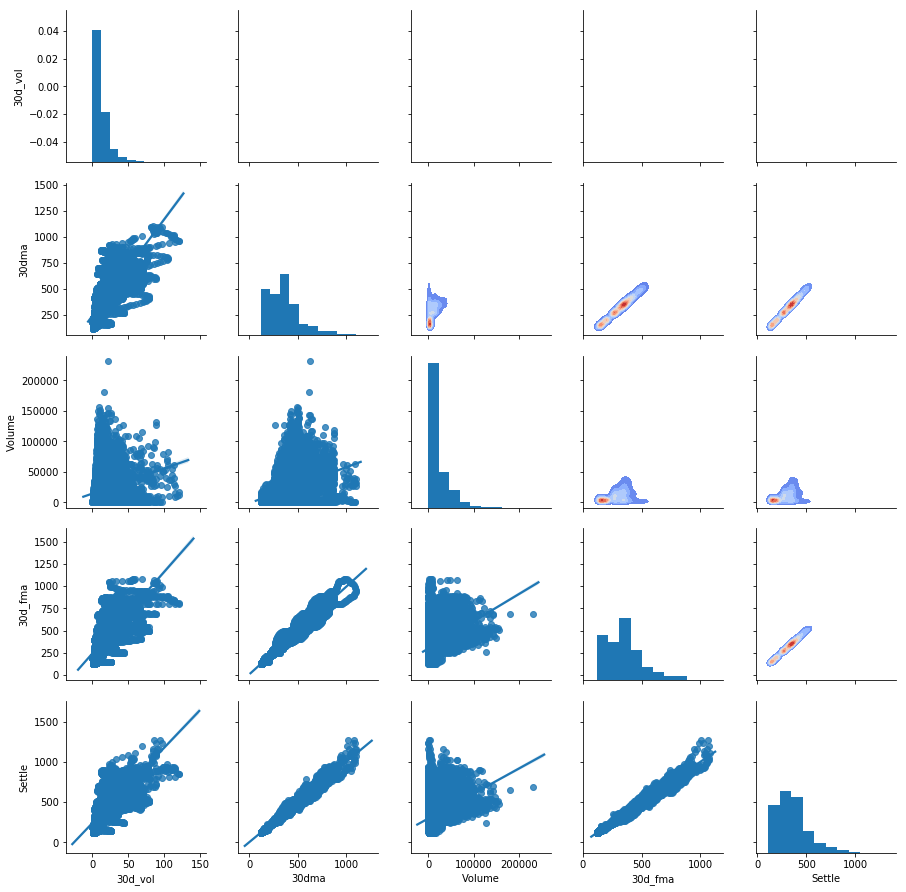

In [21]:
# Plot a pairgrid showing relationships between price and certain indicators
g = sns.PairGrid(vars = ['30d_vol', '30dma','Volume','30d_fma','Settle'], data = wheat)
g = g.map_lower(sns.regplot)    # Regression plots in lower triangle.
g = g.map_upper(sns.kdeplot, cmap="coolwarm", shade=True, shade_lowest=False)  # KDE plots in upper triangle.
g = g.map_diag(plt.hist)        # Histograms along diagonal.

# EDA: Analysis of Distribution of Returns

The distribution of returns is a very important concept in financial markets, a source of much debate, and an area of immense practical importance for trading strategies, derivatives pricing, and risk management. Most well-known models tend to assume a normal distribution of returns - on the justification that it is a 'good enough' approximation and that the math becomes much more tractable with normality. On the other hand, traders generally 'know' that returns are not normal, and that the deviations from normality present some of the biggest opportunities and risks. 

I want to see for myself how returns for wheat futures are distributed, on daily, weekly, monthly, and yearly frequencies.

In [7]:
def describe_dist(data, pvalue = 0.05):
    '''Given a series of numerical data, describe the distribution and assess if it is normal
    Perform a normal test, looking at skew and kurtosis, and return the proportion of observations
    that fall outside of 1, 2, and 3 distributions from the mean'''
    
    # Conduct a test of normality
    if normaltest(data)[1] < pvalue:
        normal = 'not normal'
    else: 
        normal = 'normal'
    
    # Standardize the data
    data['Z'] = (data - data.mean())/data.std()
    
    # Count observations in the tails
    one_sd = data[abs(data['Z']) > 1].shape[0]
    two_sd = data[abs(data['Z']) > 2].shape[0]
    three_sd = data[abs(data['Z']) > 3].shape[0]
    
    # Print out the biggest outliers
    print('Outliers:\n')
    outliers_up = data['Z'] > 2.5
    outliers_down = data['Z'] < -2.5
    print('Down:\n')
    display(data[outliers_down].sort_values(by='Z').head(10))
    print('Up:\n')
    display(data[outliers_up].sort_values(by='Z', ascending=False).head(10))
    print('')
    
    return normal, one_sd, two_sd, three_sd

In [16]:
def historical_returns_analysis(df, period):
    '''Given a time series of historical prices, return a report for the desired frequency
    Report includes summary statistics, including skew and kurtosis, as well as a plot of the returns
    versus the normal distribution'''
        
    # Dict mapping period to resampling code
    periods = {
        'D':'Daily',
        'W':'Weekly',
        'M':'Monthly',
        'Y':'Yearly',
    }
    
    print('Historical Returns: {}\n'.format(periods[period]))

    # Resample data to desired time periods
    periodic = df.resample(period).first()
    
    # Calculate returns
    returns = periodic['Settle'].pct_change().dropna()
    
    # Plot returns distribution versus normal distribution
    plt.figure(figsize = (10,7))
    plt.title('Distribution of {} Returns'.format(periods[period]))
    sns.distplot(returns, axlabel='{} Return'.format(periods[period]))
    
    # Calculate and display summary statistics
    print('Summary Statistics:')
    data_desc = returns.describe()
    data_desc = data_desc.append(pd.Series([returns.skew(), returns.kurtosis()], index = ['skew', 'kurtosis']))
    display(pd.DataFrame(data_desc, columns = ['{}'.format(periods[period])]).T)
    print('')
    
    # Describe data
    returns_df = pd.DataFrame(returns)
    returns_df.columns = [periods[period]]
    normal, one_sd, two_sd, three_sd = describe_dist(returns_df)
    
    # Summarize data
    print('''Summary: Looking at the data, it appears that the distribution of {} returns is {},
        with a skew of {} and excess kurtosis of {}. Of {} total observations, {},
        or {}% were greater than one standard deviation from the mean, {}, or {}%
        were greater than two standard deviations from the mean, and {}, or {}% were 
        greater than three standard deviations from the mean'''.format(
        periods[period], normal, round(returns.skew(), 2), round(returns.kurtosis(), 2),
        returns.shape[0], one_sd, round((one_sd/returns.shape[0])*100, 2), two_sd, 
        round((two_sd/returns.shape[0])*100, 2),three_sd, round((three_sd/returns.shape[0])*100, 2)))

Historical Returns: Daily

Summary Statistics:


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Daily,21659.0,0.000148,0.014348,-0.269553,-0.004208,0.0,0.004252,0.262327,-0.779661,29.511451



Outliers:

Down:



,Daily,Z
Date,,
1986-05-21,-0.269553,-18.796835
1964-05-20,-0.268102,-18.695686
1996-03-21,-0.248828,-17.352411
1963-05-22,-0.185739,-12.955447
1993-03-23,-0.177751,-12.398686
1986-03-20,-0.161486,-11.265138
1993-05-20,-0.151709,-10.583724
1990-05-22,-0.127119,-8.869872
1971-05-20,-0.120588,-8.414736


Up:



,Daily,Z
Date,,
1996-03-20,0.262327,18.272559
1988-06-30,0.094767,6.594414
2008-10-29,0.091926,6.396442
2009-09-15,0.091647,6.377016
2010-10-08,0.091013,6.332772
2008-03-11,0.087719,6.103251
2010-07-15,0.087551,6.091543
2004-11-25,0.084378,5.870353
2010-08-05,0.082673,5.751557



Summary: Looking at the data, it appears that the distribution of Daily returns is not normal,
        with a skew of -0.78 and excess kurtosis of 29.51. Of 21659 total observations, 4377,
        or 20.21% were greater than one standard deviation from the mean, 1213, or 5.6%
        were greater than two standard deviations from the mean, and 363, or 1.68% were 
        greater than three standard deviations from the mean


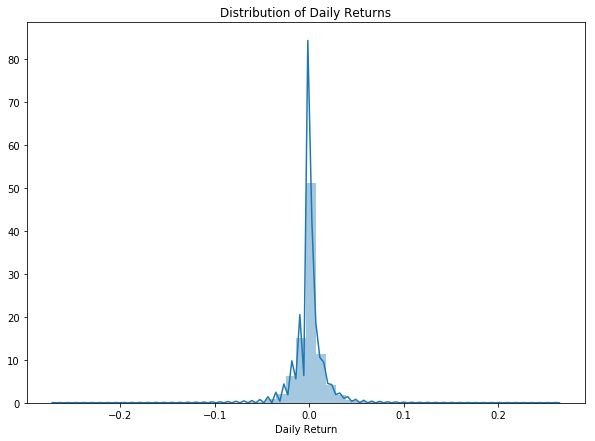

In [53]:
historical_returns_analysis(wheat, 'D')

Historical Returns: Weekly

Summary Statistics:


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Weekly,3094.0,0.001027,0.03769,-0.248039,-0.019975,0.0,0.019223,0.192778,0.1963,3.412281



Outliers:

Down:



,Weekly,Z
Date,,
1964-05-31,-0.248039,-6.608296
1986-06-01,-0.244083,-6.503324
1993-05-30,-0.181311,-4.837842
1993-04-04,-0.173519,-4.631095
1963-06-02,-0.153248,-4.093264
1974-05-12,-0.127714,-3.415787
1974-04-07,-0.127368,-3.406620
1990-06-03,-0.126467,-3.382697
1996-06-02,-0.126400,-3.380926


Up:



,Weekly,Z
Date,,
2017-07-09,0.192778,5.087600
2012-05-27,0.177750,4.688875
1974-06-30,0.176326,4.651083
2010-08-08,0.175997,4.642356
1973-08-19,0.173267,4.569942
2015-07-05,0.158105,4.167644
1975-07-20,0.157285,4.145888
2010-12-12,0.156478,4.124490
2003-05-18,0.155004,4.085385



Summary: Looking at the data, it appears that the distribution of Weekly returns is not normal,
        with a skew of 0.2 and excess kurtosis of 3.41. Of 3094 total observations, 751,
        or 24.27% were greater than one standard deviation from the mean, 169, or 5.46%
        were greater than two standard deviations from the mean, and 42, or 1.36% were 
        greater than three standard deviations from the mean


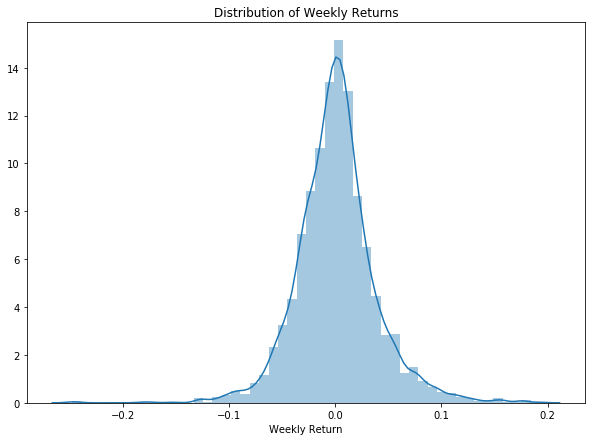

In [18]:
historical_returns_analysis(wheat, 'W')

Historical Returns: Monthly

Summary Statistics:


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Monthly,711.0,0.00441,0.079053,-0.301601,-0.040194,0.000329,0.047586,0.432335,0.511362,2.622258



Outliers:

Down:



,Monthly,Z
Date,,
1974-04-30,-0.301601,-3.870979
2009-07-31,-0.249444,-3.211208
1964-06-30,-0.243804,-3.139859
2011-07-31,-0.230161,-2.967286
1996-06-30,-0.229290,-2.956263


Up:



,Monthly,Z
Date,,
2010-08-31,0.432335,5.413161
1973-08-31,0.342330,4.274620
1996-05-31,0.321603,4.012428
1973-09-30,0.284759,3.546362
2007-09-30,0.268868,3.345338
2017-07-31,0.251166,3.121406
1975-08-31,0.250423,3.112013
2012-07-31,0.232340,2.883263
1974-07-31,0.225302,2.794238



Summary: Looking at the data, it appears that the distribution of Monthly returns is not normal,
        with a skew of 0.51 and excess kurtosis of 2.62. Of 711 total observations, 181,
        or 25.46% were greater than one standard deviation from the mean, 34, or 4.78%
        were greater than two standard deviations from the mean, and 10, or 1.41% were 
        greater than three standard deviations from the mean


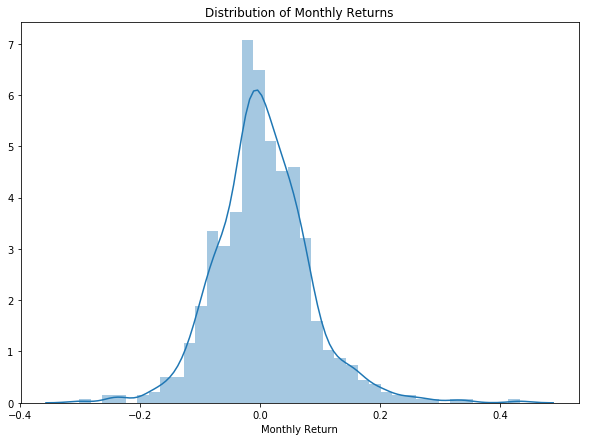

In [19]:
historical_returns_analysis(wheat, 'M')

Historical Returns: Yearly

Summary Statistics:


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Yearly,59.0,0.044668,0.278269,-0.355352,-0.15908,0.018075,0.143081,1.138862,1.571924,3.707755



Outliers:

Down:



,Yearly,Z
Date,,


Up:



,Yearly,Z
Date,,
1974-12-31,1.138862,3.932143
2008-12-31,0.826347,2.809076



Summary: Looking at the data, it appears that the distribution of Yearly returns is not normal,
        with a skew of 1.57 and excess kurtosis of 3.71. Of 59 total observations, 13,
        or 22.03% were greater than one standard deviation from the mean, 3, or 5.08%
        were greater than two standard deviations from the mean, and 1, or 1.69% were 
        greater than three standard deviations from the mean


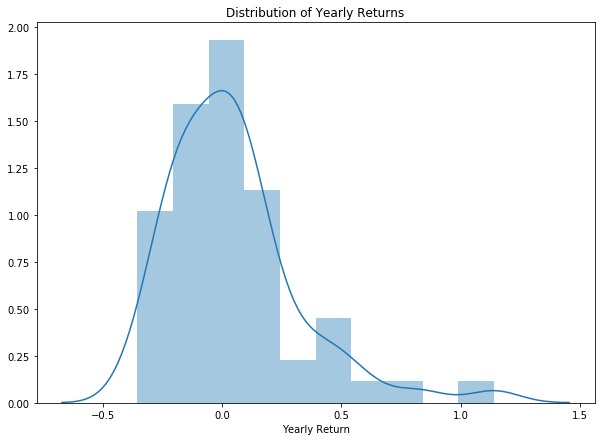

In [20]:
historical_returns_analysis(wheat, 'Y')

## Distribution of Returns: Summary of Data

As expected, the distributions of returns are not normal - on daily, weekly, monthly, or yearly time scales. Most notably, the return distributions are highly kurtotic. There are far more observations than expected within one standard deviation of the mean. What surprised me initially is that the number of observations outside of 2 and 3 standard deviations from the mean was approximately equal to what you would see in a normal distribution. Looking closer at the data, I can see that this is accounted for by the fact that there are some observations several standard deviations from the mean (several observations greater than 5 or 6 standard deviations - which is extremely unlikely in a normal distribution). So the kurtosis does not come from having more observations outside of the 3 standard deviation cutoff, as I presumed - it comes from the fact that the observations we do see in the tails are so much more spread out than expected.

The daily data are not meaningfully skewed, but as longer and longer time ranges, a positive right tail emerges. This is consistent with that the price plots show - that the extreme moves in this market are to the upside.

### Note on extreme outliers in daily data:

One aspect of the daily returns distribution concerned me, the prevalence of extreme outliers (in the 16-18 s.d. range). I noticed that there was a pattern to the dates on which these moved occurred - several of them were on March 20th, or May 20th, or 21st, etc. My hunch was that these represented expiration dates. It turns out that is the case, these extreme moves happened on around or after the market close on days when the first contract was expiring (seeing moves of this magnitude is one downside of using data for the front month contract up until the last day - as discussed above in 'Data Wrangling'). My research uncovered another interesting fact about the dates in question - the price movement on these days actually prompted CFTC investigations into potential market manipulation. One such example is documented in the settlement linked below, from March 20, 1996 (a day which say a 26% (or 18z) move in front month wheat.

https://www.cftc.gov/sites/default/files/ogc/oporders97/ogcwheat6.htm

# EDA: Visual Analysis of Autocorrelation and Partial Autocorrelation

With any time series data, it is good practice to examine autocorrelation and partial autocorrelation plots.

### Prices first...

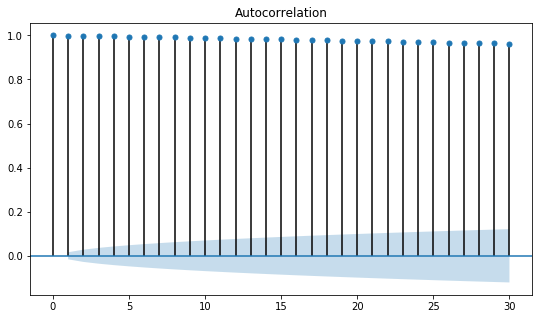

In [24]:
fig, ax = plt.subplots(figsize = (9,5))
plot_acf(wheat['Settle'], lags = 30, ax = ax)
plt.show();

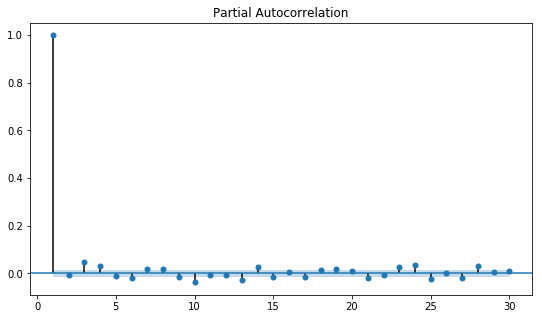

In [25]:
fig, ax = plt.subplots(figsize = (9,5))
plot_pacf(wheat['Settle'], lags=30, ax=ax, zero=False)
plt.show();

As expected, prices exhibit significant autocorrelation, well outside the confidence bands. When looking at partial autocorrelation, a stark drop off is seen after the first lag, which has an autocorrelation of almost 1.0. I interpret this as suggesting that prices represent a Markov process, where the next period's price depends heavily on today's price, but is largely unrelated to prior price history, conditional on the most recent observed price. This presents a potential limitation in my research, as the data does look very much like a 'random walk.' If so, it should not be possible to use pattern recognition on past prices to predict future prices.


### Now checking for ACF and PACF of returns...

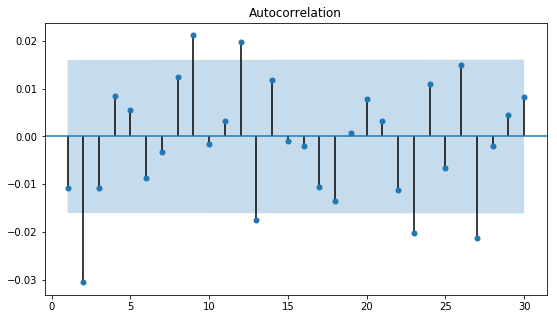

In [26]:
fig, ax = plt.subplots(figsize = (9,5))
plot_acf(wheat['Settle'].pct_change().dropna(), lags=30, ax=ax, zero=False)
plt.show();

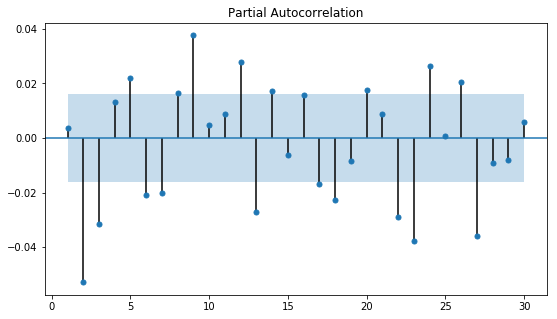

In [27]:
fig, ax = plt.subplots(figsize = (9,5))
plot_pacf(wheat['Settle'].diff().dropna(), lags=30, ax=ax, zero=False)
plt.show();

### ...and volatility

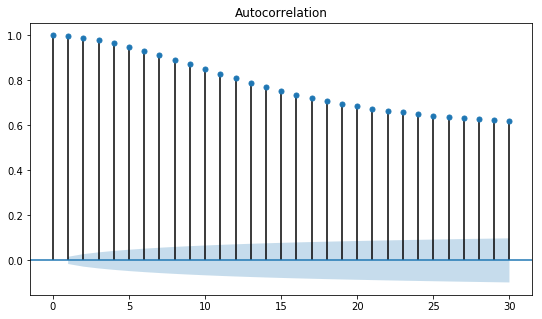

In [28]:
fig, ax = plt.subplots(figsize = (9,5))
plot_acf(wheat['30d_vol'].dropna(), lags = 30, ax = ax)
plt.show();

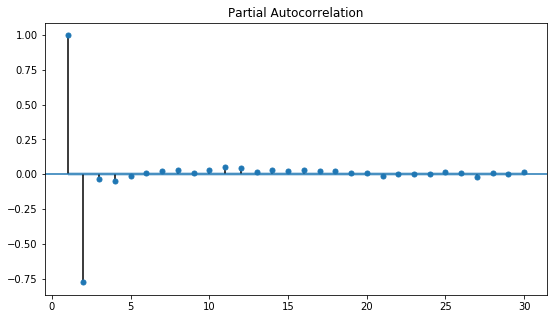

In [29]:
fig, ax = plt.subplots(figsize = (9,5))
plot_pacf(wheat['30d_vol'].dropna(), lags=30, ax=ax, zero=False)
plt.show();

Note that the first lag on volatility is very close to 1, while the second lag is significantly negative. I interpret this as saying that today's volatility is highly related to yesterday's, but actually negatively correlated to the day before. This seems to suggest a lagged stationarity in the data. This is an intriguing observation, and one I'd like to pursue in further research.

# EDA: Technical Analysis

In order to get a sense of how prices move relative to historical volatility, I will plot prices along with confidence bands (technical term is Bollinger Bands) which represent two standard deviations above and below the rolling mean.

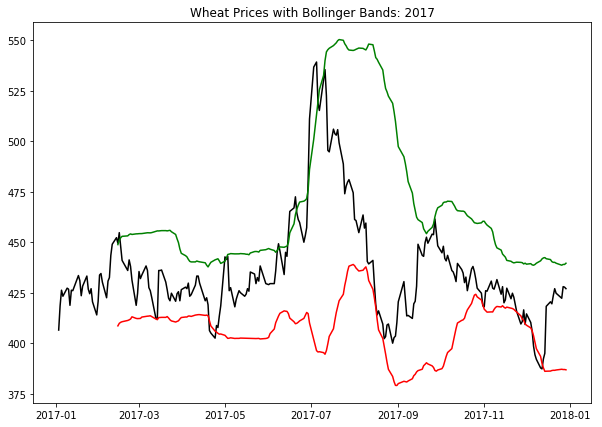

In [30]:
# Looking at 5 years of price history, price versus volatility bands
price = wheat['2017']['Settle']
upper = wheat['2017']['Settle'].rolling(30).mean() + 2 * wheat['30d_vol']
lower = wheat['2017']['Settle'].rolling(30).mean() - 2 *wheat['30d_vol']
    
plt.figure(figsize=(10,7))
plt.plot(price, color='k')
plt.plot(upper, color='g')
plt.plot(lower, color='r')
plt.title('Wheat Prices with Bollinger Bands: 2017');

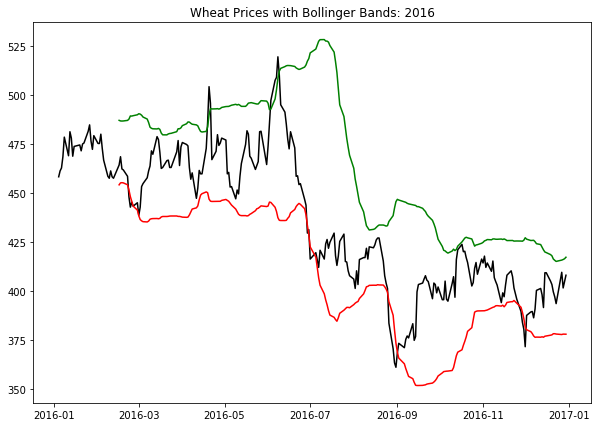

In [31]:
# Looking at 5 years of price history, price versus volatility bands
price = wheat['2016']['Settle']
upper = wheat['2016']['Settle'].rolling(30).mean() + 2 * wheat['30d_vol']
lower = wheat['2016']['Settle'].rolling(30).mean() - 2 *wheat['30d_vol']
    
plt.figure(figsize=(10,7))
plt.plot(price, color='k')
plt.plot(upper, color='g')
plt.plot(lower, color='r')
plt.title('Wheat Prices with Bollinger Bands: 2016');

# EDA: Summarize Period

The following functions all build toward being able to summarize a price history into periods of trending or ranging prices. I will utilize seasonal decomposition to break up the series into trend, cyclicality, and residual, find local min and max, and break up the time series into smaller chunks, defined as either Uptrend, Downtrend, Rangebound, or Unclassified.

Note: Some of functions here which change the data will be duplicated in the data prep notebook, but I have chosen to keep this full study in EDA as it represents a significant part of my research.

## Seasonal Decomposition

In [32]:
def get_decomposition(df, start, stop, freq=60, column='Settle'):
    '''Return seasonal decomposition for given timeframe and frequency
    Plot the original series as well as the decomposition'''
    
    # run the seasonal decomposition
    series = wheat[start:stop][column]
    decomp = seasonal_decompose(series, freq=freq)
    
    # plot the decomposition
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize = (15,15))
    series.plot(ax=axes[0], title='Price')
    decomp.trend.plot(ax=axes[1], title='Trend')
    decomp.seasonal.plot(ax=axes[2], title='Seasonal')
    decomp.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout();
    
    return decomp

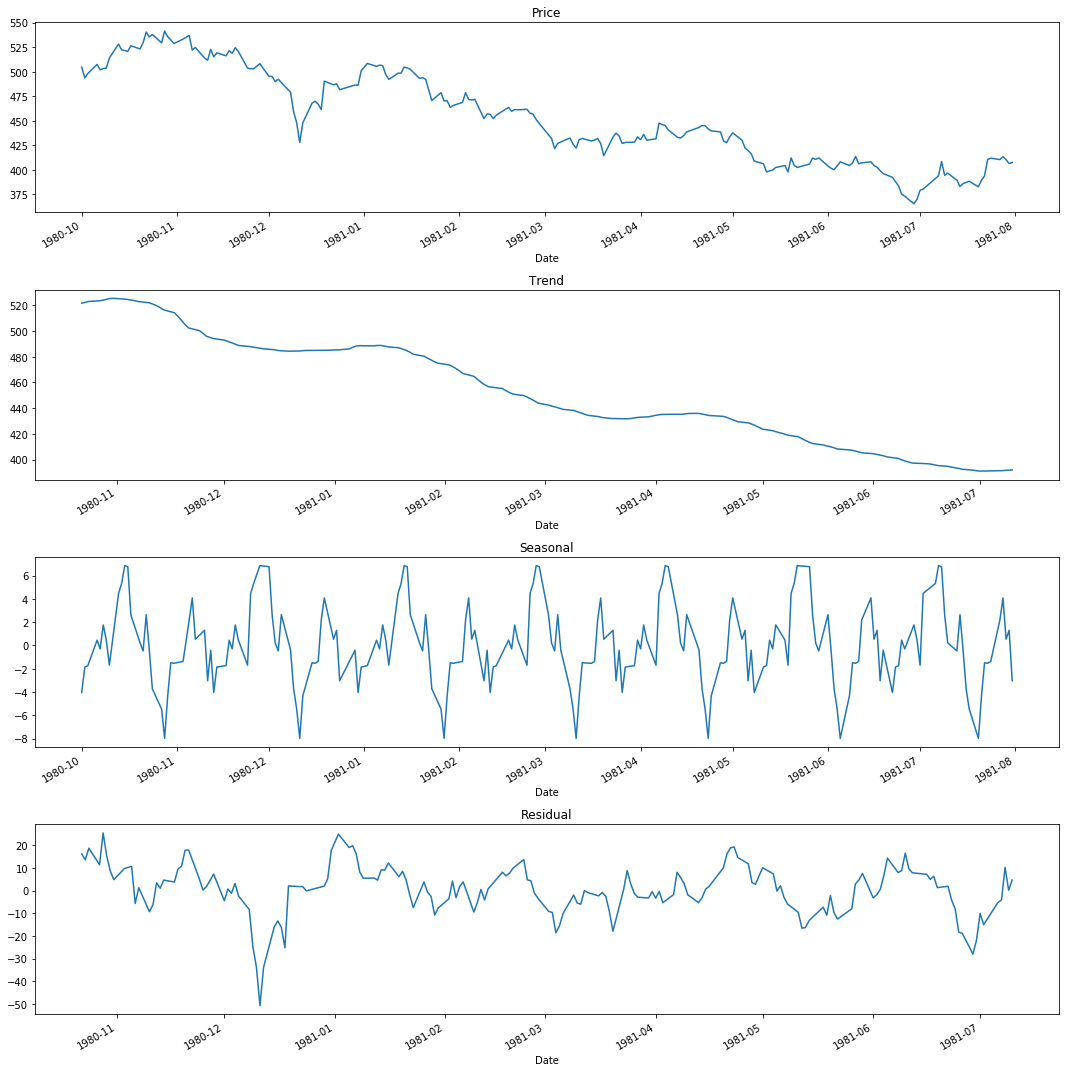

In [33]:
decomp = get_decomposition(wheat, start='1980-10', stop='1981-07', freq=30)

## Find Turning Points

In [34]:
def find_trend_turning_points(df, start, stop, decomp, order=5):
    '''Returns the local maxima and minima of smoothed time series'''
    
    # for local maxima
    maxima = argrelextrema(decomp.trend.values, np.greater, order=order) # find the location of the maxes
    max_dates = [df[start:stop].iloc[i].index for i in maxima] # get the corresponding dates
    peaks = [date for date in df[start:stop].index if date in max_dates[0]]

    # for local minima
    minima = argrelextrema(decomp.trend.values, np.less, order=order)# find location of the mins
    min_dates = [df[start:stop].iloc[i].index for i in minima] # get the corresponding dates
    troughs = [date for date in df[start:stop].index if date in min_dates[0]]
    
    return peaks, troughs

In [35]:
def find_exact_turning_points(df, peaks, troughs, order=10):
    '''Given a time series dataframe and dates of smoothed maxima and minima, find
    the exact high and low points by searching around the trend max/mins'''
    
    highs = []
    lows = []
    
    # find the exact maxs
    for date in peaks:
        start = date - pd.Timedelta(order, unit='D')
        stop = date + pd.Timedelta(order, unit='D')
        high_price_loc = df[start:stop]['High'].idxmax()
        highs.append(high_price_loc)
    
    # find the exact mins
    for date in troughs:
        start = date - pd.Timedelta(order, unit='D')
        stop = date + pd.Timedelta(order, unit='D')
        low_price_loc = df[start:stop]['Low'].idxmin()
        lows.append(low_price_loc)
        
    return highs, lows

In [36]:
peaks, troughs = find_trend_turning_points(wheat, '1980-10', '1981-07', decomp)
highs, lows = find_exact_turning_points(wheat, peaks, troughs)

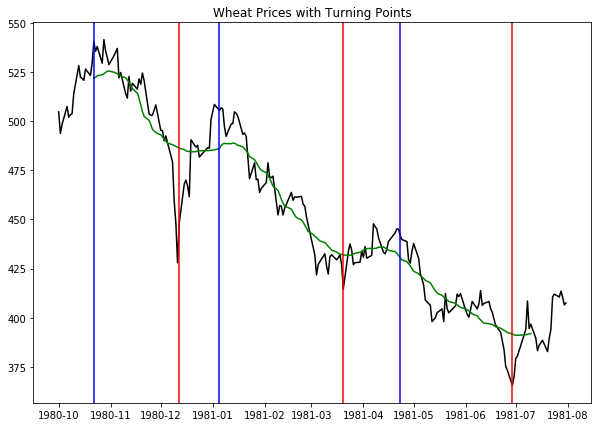

In [37]:
plt.figure(figsize=(10,7))
plt.plot(wheat['1980-10':'1981-07']['Settle'], color='k')
plt.plot(decomp.trend, color='g')
plt.title('Wheat Prices with Turning Points')

for h in highs:
    plt.axvline(x=h, color='b')

for l in lows:
    plt.axvline(x=l, color='r')

## Break down period into trends

In [38]:
def is_top_or_bottom(date, highs, lows):
    '''Check if a given date is found in list of highs or lows'''
    
    if date in highs:
        classifier = 'Top'
    elif date in lows:
        classifier = 'Bottom'
    else:
        classifier = 'Unclassified'
        
    return classifier

In [39]:
def filter_for_turns(df, highs, lows):
    '''Given a time series of prices and dates of highs and lows, filter the dataframe
    and return a new df which only contains turning points'''
    
    # Classify turning points
    df['Turning_Point'] = df.index
    df['Turning_Point'] = df['Turning_Point'].apply(is_top_or_bottom, args=(highs, lows))
    
    # Filter out points that aren't turns
    unclass = df['Turning_Point'] == 'Unclassified'
    endpoints = df[~unclass]
    
    return endpoints

In [40]:
def trend_finder(df, threshold=10):
    '''Given a dataframe of turning points from a financial time series, return a dataframe summarizing
    the trends in the series'''
    
    # Initialize an empty list to contain trends
    trends = []

    # Initialize trackers to indicate tops and bottoms have been found
    top = False
    bottom = False

    # Loop through df, collecting pairs of tops and bottoms
    # each pair is a single trend
    for i, row in df.iterrows():
        if row['Turning_Point'] == 'Top':
            if top == False:
                peak_date = i
                peak_price = row['High']
                top = True
            elif top == True:
                if row['High'] > peak_price:
                    peak_date = i
                    peak_price = row['High']
                    top = True
                else:
                    continue
        if row['Turning_Point'] == 'Bottom':
            if bottom == False:
                trough_date = i
                trough_price = row['Low']
                bottom = True
            elif bottom == True:
                if row['Low'] < trough_price:
                    trough_date = i
                    trough_price = row['Low']
                    bottom = True
                else:
                    continue
        
        # Once a top and bottom have been paired, save the dates and prices as a dict
        if top == True & bottom == True:
            trend = {'High_Date': peak_date,
                     'High_Price': peak_price,
                     'Low_Date': trough_date,
                     'Low_Price': trough_price}
            trends.append(trend)
    
            if peak_date > trough_date:
                bottom = False
            else:
                top = False
    
    # Create a dataframe to summarize each trend
    trends = pd.DataFrame(data=trends)
    trends['Direction'] = np.where(trends['High_Date'] > trends['Low_Date'],'Up','Down')
    trends['Start_Date'] = trends[['High_Date', 'Low_Date']].min(axis=1)
    trends['End_Date'] = trends[['High_Date', 'Low_Date']].max(axis=1)
    trends['Duration'] = np.where(trends['Direction'] == 'Up',
                        trends['High_Date'] - trends['Low_Date'],
                        trends['Low_Date'] - trends['High_Date'])
    
    trends['Return'] = np.where(trends['Direction'] == 'Up',
                        ((trends['High_Price'] - trends['Low_Price']) / trends['Low_Price']) * 100,
                        ((trends['Low_Price'] - trends['High_Price']) / trends['High_Price']) * 100)
    
    # Classify periods below the threshold as flat
    trends.loc[abs(trends['Return']) < threshold, 'Direction'] = 'Flat'
    
    # Code to handle one corner-case that came up in the data
    for i, row in trends.iterrows():
        if (row['Direction'] == 'Up') and (row['High_Price'] < row['Low_Price']):
            trends.loc[i, 'Direction'] = 'Down'
            trends.loc[i, 'High_Price'] = row['Low_Price']
            trends.loc[i, 'Low_Price'] = row['High_Price']
            trends.loc[i, 'High_Date'] = row['Low_Date']
            trends.loc[i, 'Low_Date'] = row['Low_Price']
    
    # Aggregate flat periods
    is_flat = False

    for i, row in trends.iterrows():
        if row['Direction'] == 'Flat':
            if is_flat == False:
                start_date = row['Start_Date']
                is_flat = True
            elif is_flat == True:
                trends.loc[i,'Start_Date'] = start_date
        if row['Direction'] != 'Flat':
            is_flat = False
            continue
    
    trends = trends.groupby(by=['Start_Date', 'Direction']).agg({'High_Price': max, 'Low_Price': min,
                                                             'Duration': sum, 'Return': 'mean',
                                                             'End_Date': max,'High_Date': max, 'Low_Date': max})[['High_Price',
                                                                'Low_Price', 'Duration', 'Return', 'End_Date',
                                                                'High_Date', 'Low_Date']].reset_index()
        
    return trends

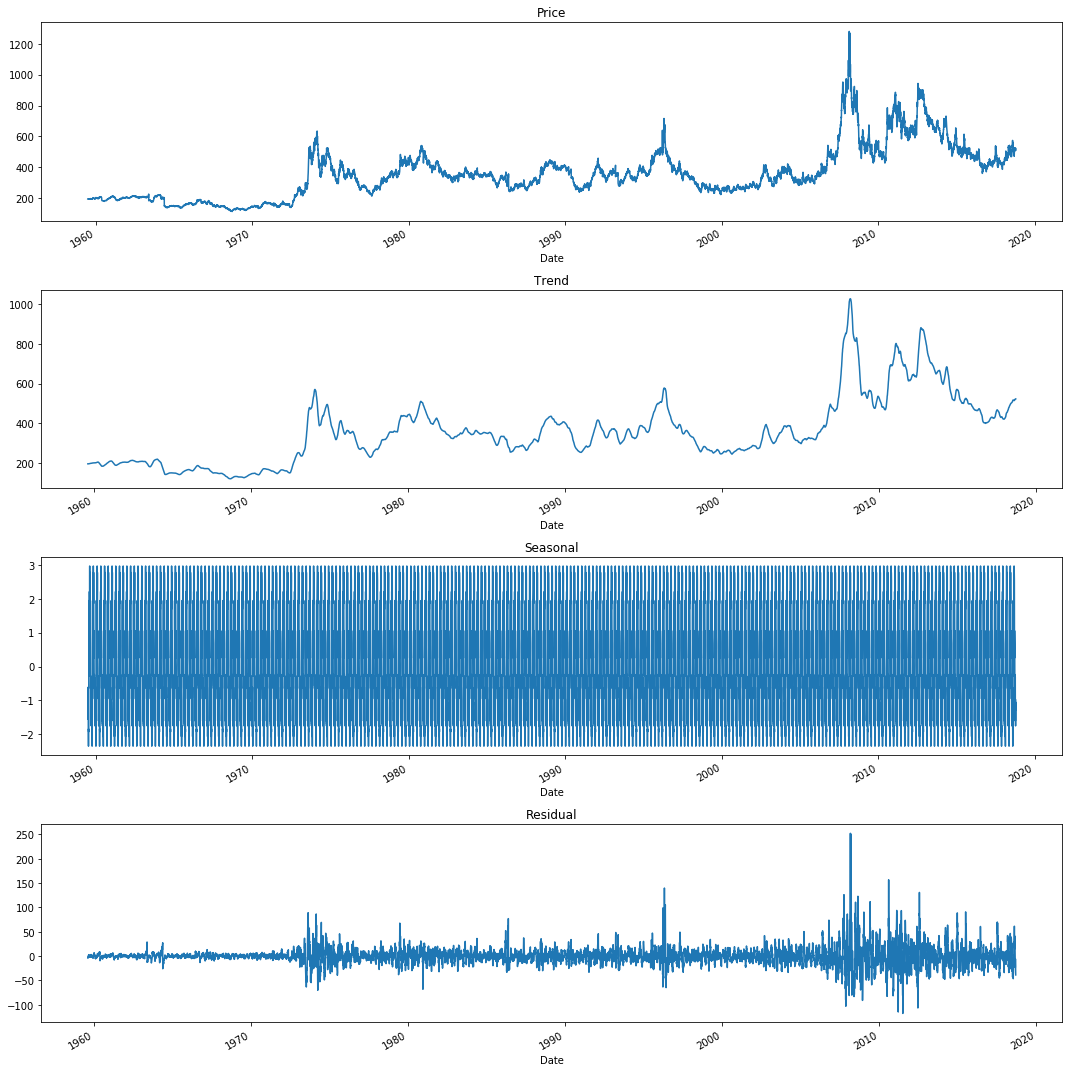

In [41]:
df = wheat
start = wheat.index[0]
stop = wheat.index[-1]

decomp = get_decomposition(df, start, stop)
peaks, troughs = find_trend_turning_points(df, start, stop, decomp)
highs, lows = find_exact_turning_points(df, peaks, troughs)
filtered_df = filter_for_turns(df, highs, lows)
trends = trend_finder(filtered_df)

In [42]:
trends[['Duration','Return']].describe().T

,count,mean,std,min,25%,50%,75%,max
Duration,208,92 days 14:46:09.230769,73 days 08:51:39.029279,3 days 00:00:00,33 days 00:00:00,80 days 00:00:00,126 days 06:00:00,488 days 00:00:00
Return,208,4.09562,26.414,-45.7766,-12.6307,-0.0860306,17.7736,159.716


# Summary Statistics on Regimes

Regimes tend to last, on average, 92 days, with significant variation. The shortest regime recorded was only 3 days long, and the longest lasted well over a year. The median regime had slightly negative total return, and there is a long right tail on regime returns, consistent with the positive skewness observed in the distribution of returns above. 

In [43]:
signal = abs(trends['Return']) > 10
trends[signal].describe().T

trends[trends['Direction'] == 'Up'].sort_values(by='Return', ascending=True).head()

,Start_Date,Direction,High_Price,Low_Price,Duration,Return,End_Date,High_Date,Low_Date
195,2016-03-02,Up,479.5,435.25,12 days,10.166571,2016-03-14,2016-03-14,2016-03-02 00:00:00
124,2000-04-27,Up,265.5,240.50,7 days,10.395010,2000-05-04,2000-05-04,2000-04-27 00:00:00
63,1979-11-02,Up,445.0,402.00,12 days,10.696517,1979-11-14,1979-11-14,1979-11-02 00:00:00
160,2009-01-20,Up,610.0,549.00,6 days,11.111111,2009-01-26,2009-01-26,2009-01-20 00:00:00
4,1961-05-26,Up,206.3,184.50,195 days,11.815718,1961-12-07,1961-12-07,1961-05-26 00:00:00


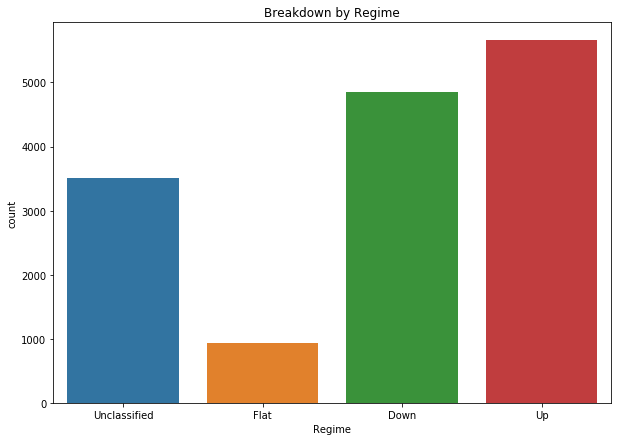

In [44]:
plt.figure(figsize=(10,7))
plt.title('Breakdown by Regime')
sns.countplot(x='Regime', data=wheat);

Note that the majority of observations in the data come from trends (upward or downward) in which the market moved at least 10% between turning points. This supports the hypotheses that the market trends more often than ranges (the market is only considered 'Flat' about 7% of the time), and that trends tend to persist,once formed. This, coupled with the data on duration and returns from trends, suggests evidence in favor of a trend following strategy.

""


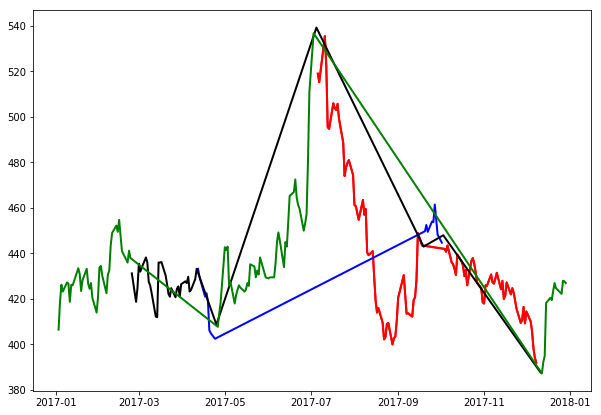

In [56]:
fig, ax = plt.subplots(figsize=(10,7))

def plot_period(group):
    global ax
    if (group['Regime'] == 'Up').all():
        color = 'g'
    elif (group['Regime'] == 'Down').all():
        color = 'r'
    elif (group['Regime'] == 'Flat').all():
        color = 'b'
    else:
        color = 'k'
    
    lw = 2.0
    ax.plot(group.index, group.Settle, c=color, linewidth=lw, inter)

wheat['2017'].groupby(['Regime']).apply(plot_period)